In [73]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import mean_absolute_error, mean_squared_error

import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers, Input, Model

import os
import kagglehub
path = kagglehub.dataset_download("robikscube/hourly-energy-consumption")

In [96]:
import sys
sys.path.append('/kaggle/input/window-generator')
from window_generator import WindowGenerator

In [121]:
import sys
sys.path.append('/kaggle/input/window-generator0')
from window_generator_ import WindowGenerator

In [122]:
america_electric_power = pd.read_csv("/kaggle/input/hourly-energy-consumption/AEP_hourly.csv").set_index("Datetime")
america_electric_power.head()

,AEP_MW
Datetime,
2004-12-31 01:00:00,13478.0
2004-12-31 02:00:00,12865.0
2004-12-31 03:00:00,12577.0
2004-12-31 04:00:00,12517.0
2004-12-31 05:00:00,12670.0


In [123]:
scaler = StandardScaler()
america_electric_power["AEP_MW"] = scaler.fit_transform(america_electric_power[["AEP_MW"]])

In [124]:
length = len(america_electric_power)
train_df = america_electric_power[ : int(length * 0.7)]
val_df = america_electric_power[int(length * 0.7) : int(length * 0.9)]
test_df = america_electric_power[int(length * 0.9) : ]

In [125]:
wg = WindowGenerator(input_width = 24, label_width = 24, shift = 24,
                    train_df = train_df, val_df = val_df, test_df = test_df, label_columns = ["AEP_MW"])
wg

Total window size: 48
Input indices: [ 0  1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22 23]
Label indices: [24 25 26 27 28 29 30 31 32 33 34 35 36 37 38 39 40 41 42 43 44 45 46 47]
Label column name(s): ['AEP_MW']

In [7]:
MAX_EPOCHS = 20

def compile_and_fit(model, window, patience = 2):
    early_stopping = keras.callbacks.EarlyStopping(monitor = 'val_loss', patience = patience, mode = 'min')
    model.compile(loss = keras.losses.MeanSquaredError(),
                 optimizer = keras.optimizers.Adam(),
                 metrics = [keras.metrics.MeanAbsoluteError()])
    history = model.fit(window.train, epochs = MAX_EPOCHS,
                       validation_data = window.val,
                       callbacks = [early_stopping])
    return history

# LSTM Encoder + Attention Decoder

In [8]:
encoder_inputs = Input(shape = (24, 1))
encoder_lstm = layers.LSTM(64, return_sequences=True, return_state=True)
encoder_outputs, state_h, state_c = encoder_lstm(encoder_inputs)
encoder_states = [state_h, state_c]

decoder_inputs = Input(shape = (24, 1))
decoder_lstm = layers.LSTM(64, return_sequences=True, return_state=True)
decoder_outputs, _, _ = decoder_lstm(decoder_inputs, initial_state=encoder_states)

attention = layers.Attention()
context_vector = attention([decoder_outputs, encoder_outputs])

decoder_combined_context = layers.Concatenate(axis=-1)([decoder_outputs, context_vector])

outputs = layers.TimeDistributed(layers.Dense(1))(decoder_combined_context)

modelLSTMAttention = Model(inputs=[encoder_inputs, decoder_inputs], outputs=outputs)
historyLSTMAttention = compile_and_fit(modelLSTMAttention, wg)

Epoch 1/20


I0000 00:00:1753040283.135100      99 cuda_dnn.cc:529] Loaded cuDNN version 90300


2652/2652 ━━━━━━━━━━━━━━━━━━━━ 30s 9ms/step - loss: 0.2191 - mean_absolute_error: 0.3474 - val_loss: 0.1428 - val_mean_absolute_error: 0.2781
Epoch 2/20
2652/2652 ━━━━━━━━━━━━━━━━━━━━ 24s 9ms/step - loss: 0.1189 - mean_absolute_error: 0.2541 - val_loss: 0.1318 - val_mean_absolute_error: 0.2657
Epoch 3/20
2652/2652 ━━━━━━━━━━━━━━━━━━━━ 24s 9ms/step - loss: 0.1087 - mean_absolute_error: 0.2406 - val_loss: 0.1263 - val_mean_absolute_error: 0.2550
Epoch 4/20
2652/2652 ━━━━━━━━━━━━━━━━━━━━ 24s 9ms/step - loss: 0.1022 - mean_absolute_error: 0.2317 - val_loss: 0.1167 - val_mean_absolute_error: 0.2439
Epoch 5/20
2652/2652 ━━━━━━━━━━━━━━━━━━━━ 24s 9ms/step - loss: 0.0958 - mean_absolute_error: 0.2235 - val_loss: 0.1255 - val_mean_absolute_error: 0.2548
Epoch 6/20
2652/2652 ━━━━━━━━━━━━━━━━━━━━ 24s 9ms/step - loss: 0.0886 - mean_absolute_error: 0.2145 - val_loss: 0.1210 - val_mean_absolute_error: 0.2417


# Transformer

In [69]:
class PositionalEncoding(tf.keras.layers.Layer):
    def __init__(self):
        super().__init__()

    def get_angles(self, pos, i, d_model):
        angle_rates = 1 / tf.pow(10000.0, (2 * (i // 2)) / tf.cast(d_model, tf.float32))
        return pos * angle_rates

    def call(self, inputs):
        seq_len = tf.shape(inputs)[1]
        d_model = tf.shape(inputs)[2]

        pos = tf.cast(tf.range(seq_len)[:, tf.newaxis], tf.float32)
        i = tf.cast(tf.range(d_model)[tf.newaxis, :], tf.float32)

        angle_rads = self.get_angles(pos, i, d_model)

        sines = tf.math.sin(angle_rads[:, 0::2])
        cosines = tf.math.cos(angle_rads[:, 1::2])

        pos_encoding = tf.concat([sines, cosines], axis=-1)
        pos_encoding = pos_encoding[tf.newaxis, ...]

        return inputs + tf.cast(pos_encoding, dtype=tf.float32)


In [70]:
class Transformer(layers.Layer):
    def __init__(self, embed_dim, num_heads, ff_dim):
        super().__init__()
        self.multi_head_attention = layers.MultiHeadAttention(num_heads = num_heads, key_dim = embed_dim)
        self.feed_foward_network = keras.Sequential([
            layers.Dense(ff_dim, activation = 'relu'),
            layers.Dense(embed_dim)
        ])
        self.normalization1 = layers.LayerNormalization(epsilon = 1e-6)
        self.normalization2 = layers.LayerNormalization(epsilon = 1e-6)

    def call(self, inputs):
        attention_outputs = self.multi_head_attention(inputs, inputs)
        output1 = self.normalization1(inputs + attention_outputs)
        feed_foward_network_output = self.feed_foward_network(output1)
        return self.normalization2(output1 + feed_foward_network_output)

In [71]:
inputs = layers.Input(shape = (24, 1))

x = PositionalEncoding()(inputs)
x = Transformer(embed_dim = 64, num_heads = 4, ff_dim = 128)(x)
x = layers.GlobalAveragePooling1D()(x)
x = layers.Dense(24)(x)

outputs = layers.Reshape((24, 1))(x)

transformer = Model(inputs = inputs, outputs = outputs)
historytransformer = compile_and_fit(transformer, wg)

Epoch 1/20


I0000 00:00:1753043467.076748     100 service.cc:148] XLA service 0x3fb6fb60 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
I0000 00:00:1753043467.077511     100 service.cc:156]   StreamExecutor device (0): Tesla P100-PCIE-16GB, Compute Capability 6.0


  57/2652 ━━━━━━━━━━━━━━━━━━━━ 7s 3ms/step - loss: 1.3065 - mean_absolute_error: 0.9065  

I0000 00:00:1753043469.011428     100 device_compiler.h:188] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.


2652/2652 ━━━━━━━━━━━━━━━━━━━━ 18s 4ms/step - loss: 0.9962 - mean_absolute_error: 0.7983 - val_loss: 1.1379 - val_mean_absolute_error: 0.8933
Epoch 2/20
2652/2652 ━━━━━━━━━━━━━━━━━━━━ 9s 3ms/step - loss: 0.9777 - mean_absolute_error: 0.7916 - val_loss: 1.1124 - val_mean_absolute_error: 0.8806
Epoch 3/20
2652/2652 ━━━━━━━━━━━━━━━━━━━━ 10s 4ms/step - loss: 0.9760 - mean_absolute_error: 0.7909 - val_loss: 1.1329 - val_mean_absolute_error: 0.8909
Epoch 4/20
2652/2652 ━━━━━━━━━━━━━━━━━━━━ 9s 3ms/step - loss: 0.9754 - mean_absolute_error: 0.7906 - val_loss: 1.1154 - val_mean_absolute_error: 0.8822


# Visualization

In [91]:
def plotResults(history, model_name = 'Model'):
    metrics = ['mean_absolute_error', 'loss']
    val_metrics = ['val_mean_absolute_error', 'val_loss']

    epochs = range(1, len(history['loss']) + 1)

    fig, axes = plt.subplots(1, 2, figsize=(25, 5))

    for i, (metric, val_metric) in enumerate(zip(metrics, val_metrics)):
        ax = axes[i]
        ax.plot(epochs, history[metric], label=f'Train {metric}')
        ax.plot(epochs, history[val_metric], label=f'Val {metric}')
        ax.set_title(metric)
        ax.set_xlabel('Epochs')
        ax.set_ylabel(metric)
        ax.legend()

    plt.suptitle(model_name, fontsize = 16)
    plt.tight_layout()
    plt.show()

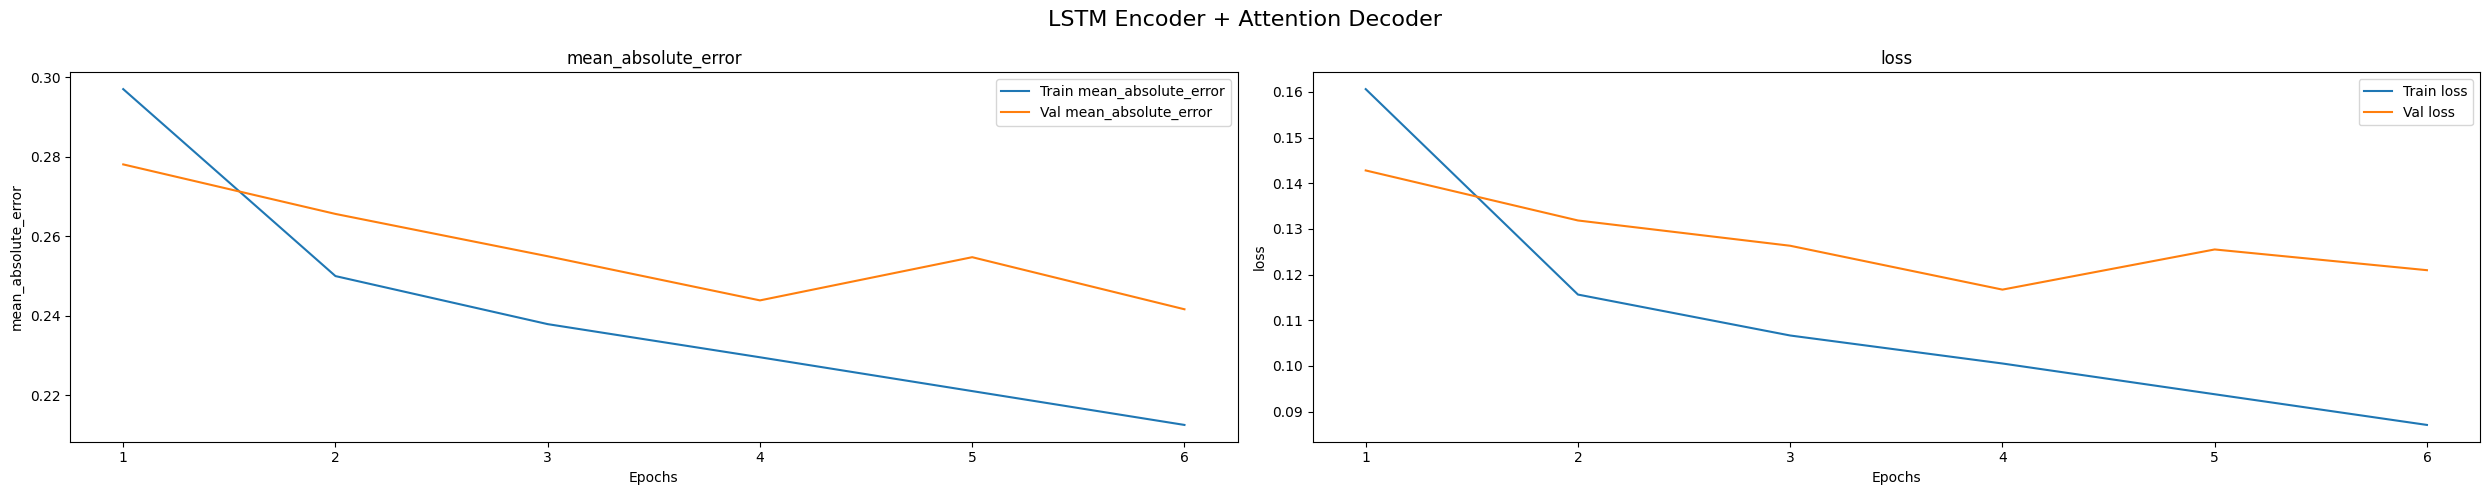

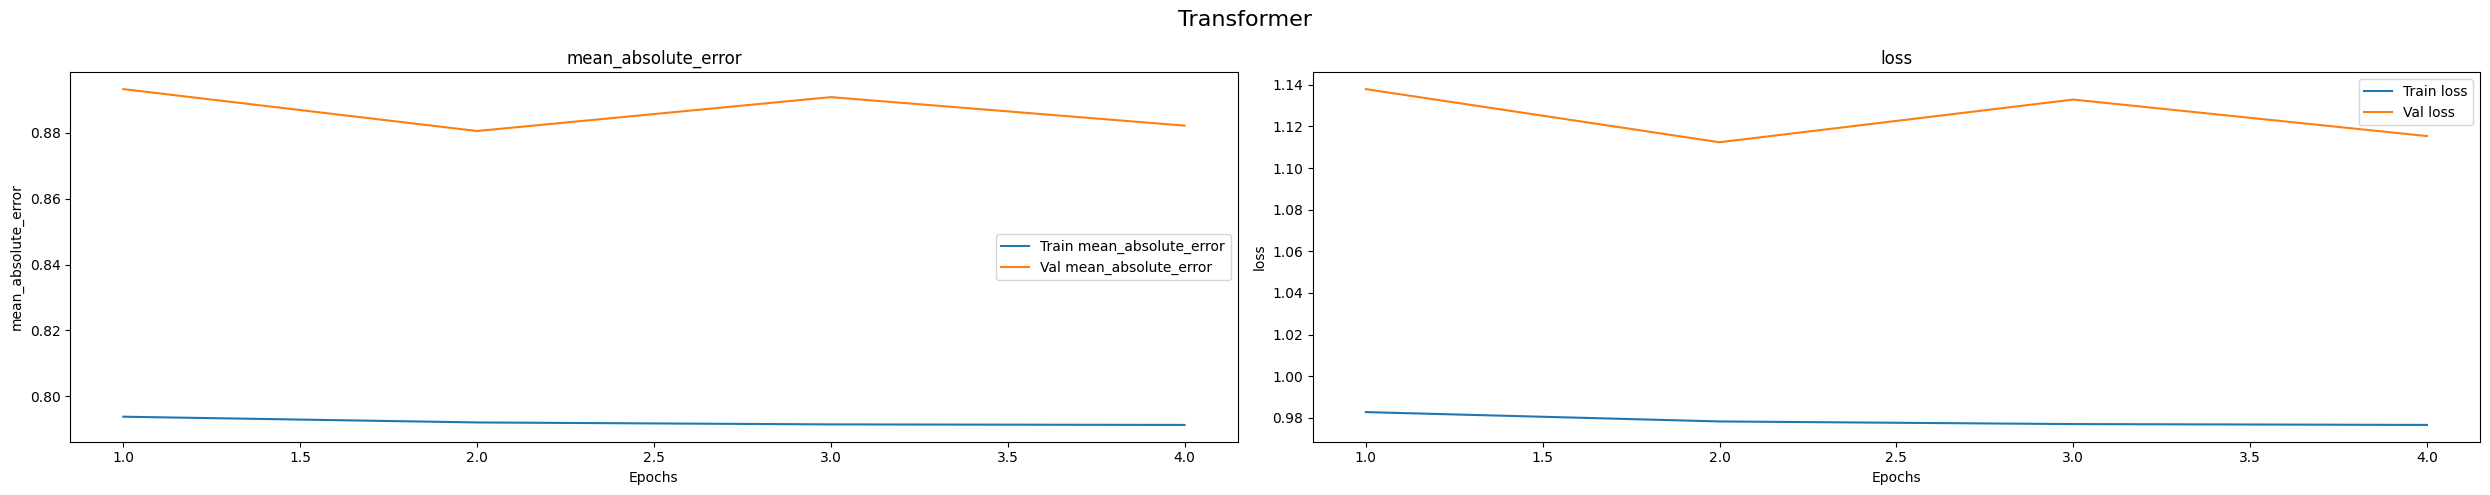

In [93]:
plotResults(historyLSTMAttention.history, model_name = "LSTM Encoder + Attention Decoder")
plotResults(historytransformer.history, model_name = "Transformer")

# Evaluation

In [74]:
def evaluation(model, window, history):
    evaluation = model.evaluate(window.test)
    predictions = model.predict(window.test)
    grouth_true = np.concatenate([y.numpy() for _, y in wg.test], axis = 0).squeeze()
    mae = mean_absolute_error(predictions.flatten(), grouth_true.flatten())
    rmse = mean_squared_error(predictions.flatten(), grouth_true.flatten(), squared = False)
    num_epochs = len(history["loss"])
    return predictions, mae, rmse, num_epochs

In [83]:
predsLSTMAttention, maeLSTMAttention, rmseLSTMAttention, epochsLSTMAttention = evaluation(modelLSTMAttention, wg, historyLSTMAttention.history)
print(f"LSTM Encoder + Attention Decoder Mean Absolute Error: {maeLSTMAttention}")
print(f"LSTM Encoder + Attention Decoder Root Mean Squared Error: {rmseLSTMAttention}")
print(f"Number of epochs before early stopping: {epochsLSTMAttention}")

378/378 ━━━━━━━━━━━━━━━━━━━━ 2s 4ms/step - loss: 0.1376 - mean_absolute_error: 0.2589
378/378 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step
LSTM Encoder + Attention Decoder Mean Absolute Error: 1.0510553121566772
LSTM Encoder + Attention Decoder Root Mean Squared Error: 1.3181296586990356
Number of epochs before early stopping: 6


In [89]:
predstransformer, maetransformer, rmsetransformer, epochstransformer = evaluation(transformer, wg, historytransformer.history)
print(f"Transformer Mean Absolute Error: {maetransformer}")
print(f"Transformer Root Mean Squared Error: {rmsetransformer}")
print(f"Number of epochs before early stopping: {epochstransformer}")

378/378 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - loss: 1.0549 - mean_absolute_error: 0.8563
378/378 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step
Transformer Mean Absolute Error: 0.8537236452102661
Transformer Root Mean Squared Error: 1.0246695280075073
Number of epochs before early stopping: 4


# Forecasting

In [109]:
def forecasting_lstm(predictions, window):
    x_sample, y_sample = window.example[0]
    y_pred = predictions
    
    input_range = np.arange(window.input_width)
    label_range = np.arange(window.input_width, window.total_window_size)
    
    plt.figure(figsize=(20, 4))
    plt.plot(input_range, x_sample[0], label='Input', marker='.')
    plt.plot(label_range, y_sample[0], label='Ground Truth', marker='o')
    plt.plot(label_range, y_pred[0], label='Forecast', marker='x')
    plt.legend()
    plt.grid(True)
    plt.show()


In [127]:
def forecasting_transformer(predictions, window):
    window_idx = 0

    input_range = np.arange(24)
    label_range = np.arange(24, 48)
    
    x, y = next(iter(window.test))
    x_sample = x[window_idx].numpy().squeeze()
    y_sample = y[window_idx].numpy().squeeze()
    y_pred = predictions[window_idx]
    
    plt.figure(figsize = (20, 4))
    plt.plot(input_range, x_sample, label = 'Input', marker = '.')
    plt.plot(label_range, y_sample, label = "Grouth True", marker = 'o')
    plt.plot(label_range, y_pred, label = "Forecast", marker = 'x')
    plt.title("Single Window Forecast")
    plt.xlabel("Time Step")
    plt.legend()
    plt.grid()
    plt.show()

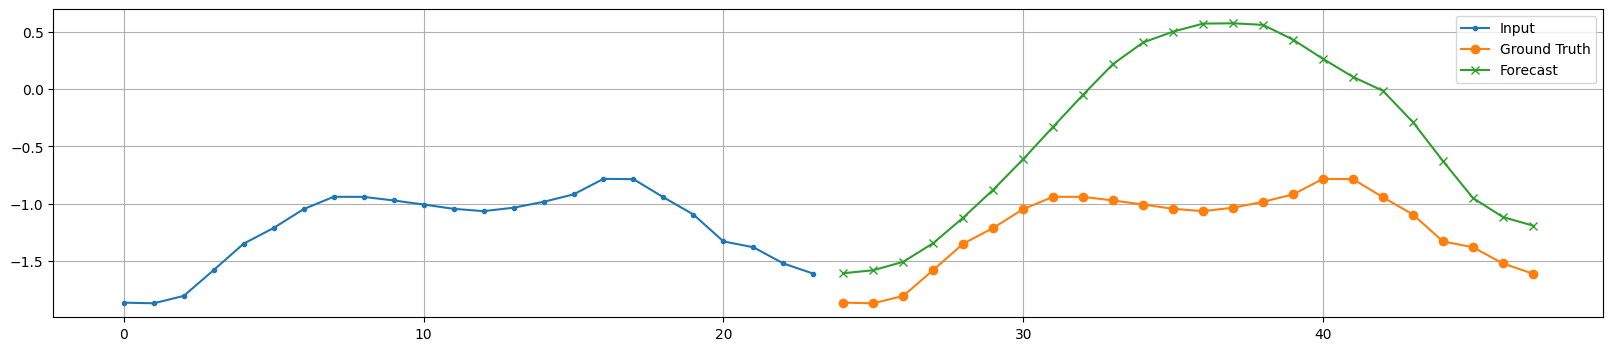

In [110]:
forecasting_lstm(predsLSTMAttention, wg)

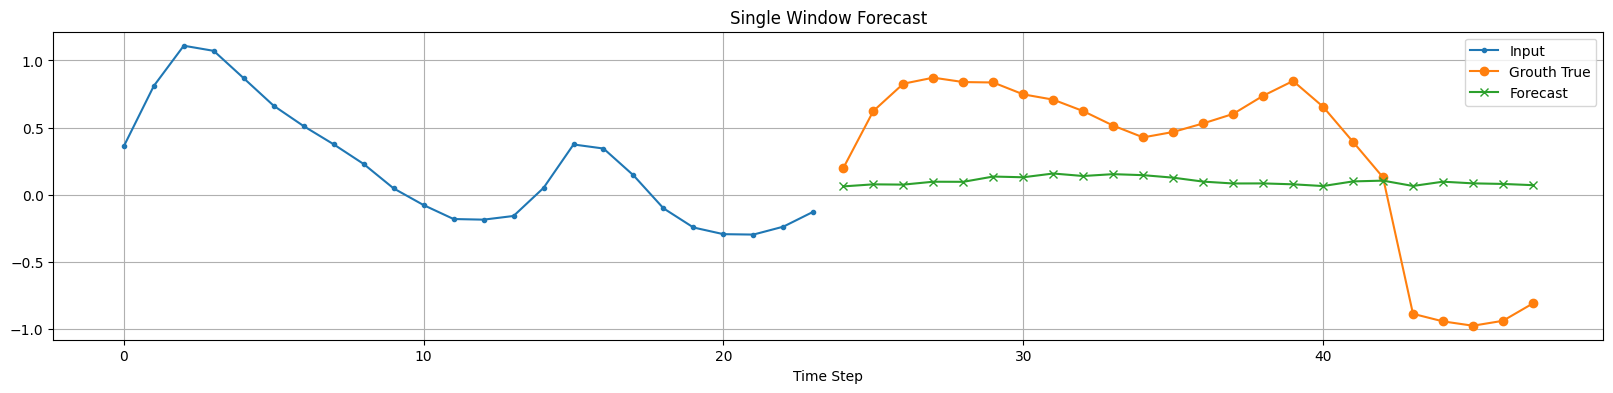

In [129]:
forecasting_transformer(predstransformer, wg)